In [218]:
from sklearn import datasets
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from simulation.network import AttractorNetwork, Langevin, relax, inverse_Langevin
from simulation.utils import fetch_digits_data, preprocess_digits_data, continous_inference_and_learning, get_deterministic_attractors
from joblib import Parallel, delayed
from copy import deepcopy
from tqdm import tqdm


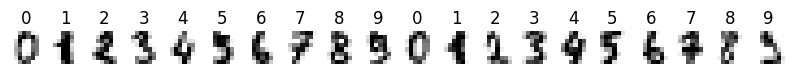

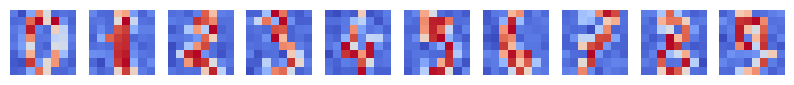

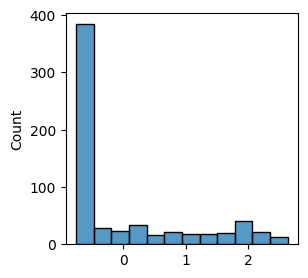

In [219]:
digits = fetch_digits_data()
train_data, _ = preprocess_digits_data(digits)

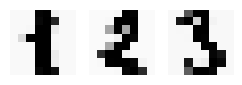

<Axes: ylabel='Count'>

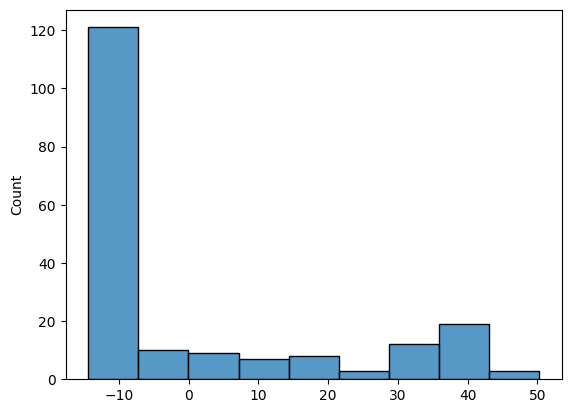

In [220]:
data = train_data[1:4].copy()
data *= 20

fig, axes = plt.subplots(nrows=10, ncols=10, figsize=(10, 10))
axes = axes.flatten()

for i, ax in enumerate(axes):
    if i < data.shape[0]:
        image = data[i].reshape(8, 8) + np.random.normal(0, 0.1, (8,8)) 
        for j in range(image.shape[0]):
            for k in range(image.shape[1]):
                image[j, k] = Langevin(image[j, k])

        ax.imshow(image, cmap="gray_r", interpolation="nearest", vmin=-np.max(image), vmax=np.max(image))
        ax.set_axis_off()
    else:
        ax.set_visible(False)

plt.show()
sns.histplot(data.flatten())

In [221]:
size = data.shape[1]
num_variables = data.shape[0]
J = np.zeros((size, size))
nw = AttractorNetwork(J, biases = np.zeros(J.shape[0]))

## Present data in a fixed order and extremely short epochs (1 step)

100%|██████████| 2000/2000 [00:11<00:00, 172.94it/s]


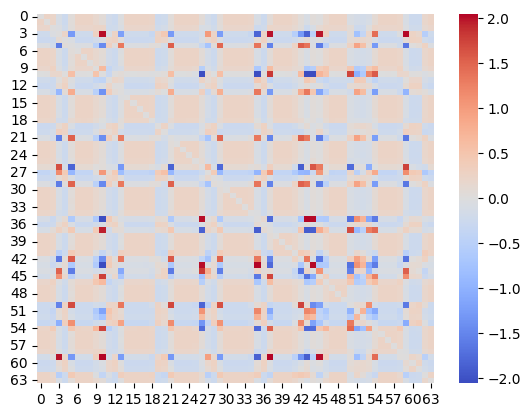

In [222]:
num_iterations = 2000

for i in tqdm(range(num_iterations)):
    di = i % data.shape[0] #np.random.randint(0, data.shape[0])
    activations, weight_change, accuracy, complexity, vfe = continous_inference_and_learning(
        nw=nw, 
        data=data[di], 
        inverse_temperature=1, 
        learning_rate=0.001, 
        num_steps=1)
    
sns.heatmap(nw.get_J(), cmap="coolwarm", center=0)
plt.show()

#for i, pattern_idx in enumerate(pattern):
#    plt.text(i*num_runs, max(error[i*num_runs:i*num_runs+num_runs]), str(pattern_idx), ha='center', va='bottom')


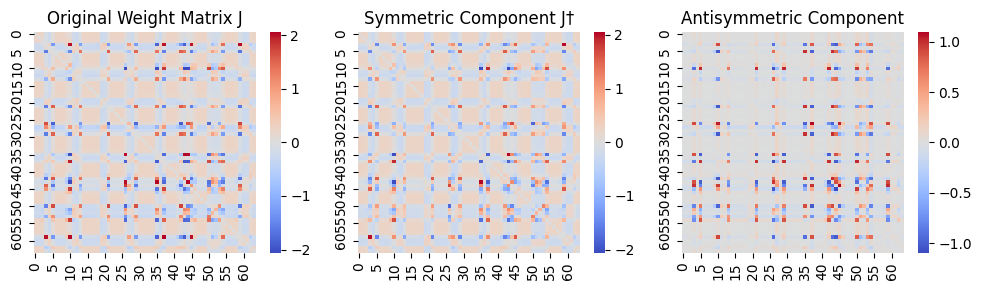

Asymmetry measure: 0.981247


In [223]:
# Symmetrize the weight matrix J
J = nw.get_J()
J_symmetrized = 0.5 * (J + J.T)  # J_ij† = (1/2) * (J_ij + J_ji)

# Display the original and symmetrized weight matrices
fig, axes = plt.subplots(1, 3, figsize=(10, 3))
sns.heatmap(J, cmap="coolwarm", center=0, ax=axes[0])
axes[0].set_title("Original Weight Matrix J")

sns.heatmap(J_symmetrized, cmap="coolwarm", center=0, ax=axes[1])
axes[1].set_title("Symmetric Component J†")


# Calculate the asymmetric component of the weight matrix
J_asymmetric = 0.5 * (J - J.T)  # J_ij‡ = (1/2) * (J_ij - J_ji)

# Display the asymmetric component
sns.heatmap(J_asymmetric, cmap="coolwarm", center=0, ax=axes[2])
axes[2].set_title("Antisymmetric Component")
plt.tight_layout()
plt.show()



# Calculate and print the asymmetry measure
asymmetry = np.linalg.norm(J - J.T) / np.linalg.norm(J)
print(f"Asymmetry measure: {asymmetry:.6f}")


/var/folders/rc/b4064_3d4dj60wt9y_447fyr0000gn/T/ipykernel_2525/4240155354.py:8: RuntimeWarning: invalid value encountered in sqrt
  Q = eigenvectors @ np.diag(np.sqrt(eigenvalues)) # only the positive eigenvalues survive, See Kanter, I., & Sompolinsky, H. (1987).


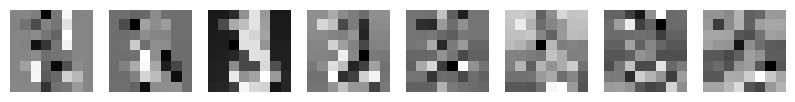

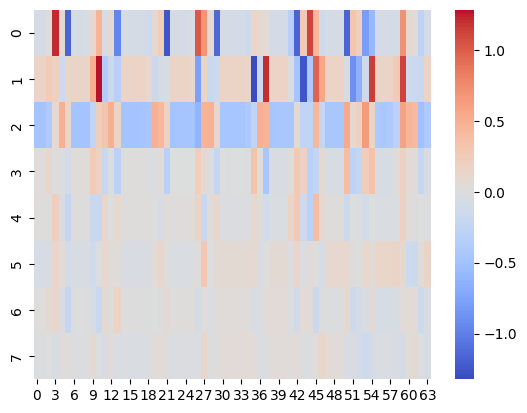

<Axes: >

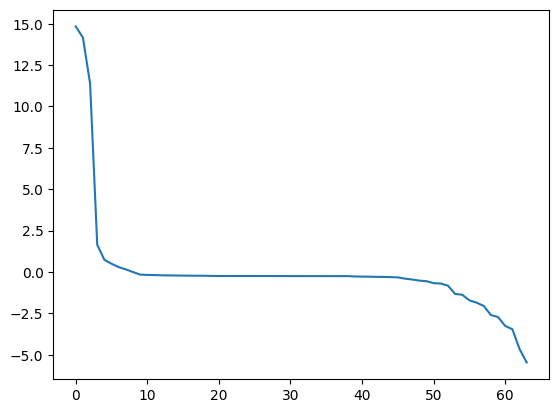

In [224]:
# Eigenvalue decomposition of J
eigenvalues, eigenvectors = np.linalg.eigh(nw.get_J())
# Sort eigenvalues and corresponding eigenvectors in descending order
idx = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx]
# Compute the weight matrix Q?
Q = eigenvectors @ np.diag(np.sqrt(eigenvalues)) # only the positive eigenvalues survive, See Kanter, I., & Sompolinsky, H. (1987).

Q = Q[:, :np.sum(eigenvalues > 0)].T # drop na-s, basically, and transpose

#best_matches = []
#for i in range(Q.shape[0]):
#    best_match = -1
#    best_match_index = -1
#    for j in range(data.shape[0]):
#        corr = np.abs(np.corrcoef(Q[i, :], data[j, :])[0, 1])
#        if corr > best_match:
#            best_match = corr
#            best_match_index = j
#    print(f"Best match for column {i} is {best_match_index} with correlation {best_match}")
#    best_matches.append(best_match_index)
#Q_sorted = Q[best_matches, :]
Q_sorted = Q

fig, ax = plt.subplots(1, np.sum(eigenvalues > 0), figsize=(10, 3))
for i in range(np.sum(eigenvalues > 0)):
    ax[i].set_axis_off()
    if Q_sorted[0, i] > 0:
        ax[i].imshow(Q_sorted[i, :].reshape(digits.images.shape[1], digits.images.shape[2]), cmap="gray", interpolation="nearest")
    else:
        ax[i].imshow(Q_sorted[i, :].reshape(digits.images.shape[1], digits.images.shape[2]), cmap="gray_r", interpolation="nearest")
    #ax[i].set_title(f"eigenvalue {eigenvalues[i]}")

plt.show()
sns.heatmap(Q, cmap="coolwarm", center=0)
plt.show()
sns.lineplot(eigenvalues)

In [225]:
acts, weight_change, accuracy, complexity, vfe = continous_inference_and_learning(
    nw, np.zeros(data.shape[1]), inverse_temperature=1, 
    learning_rate=0, num_steps=100)

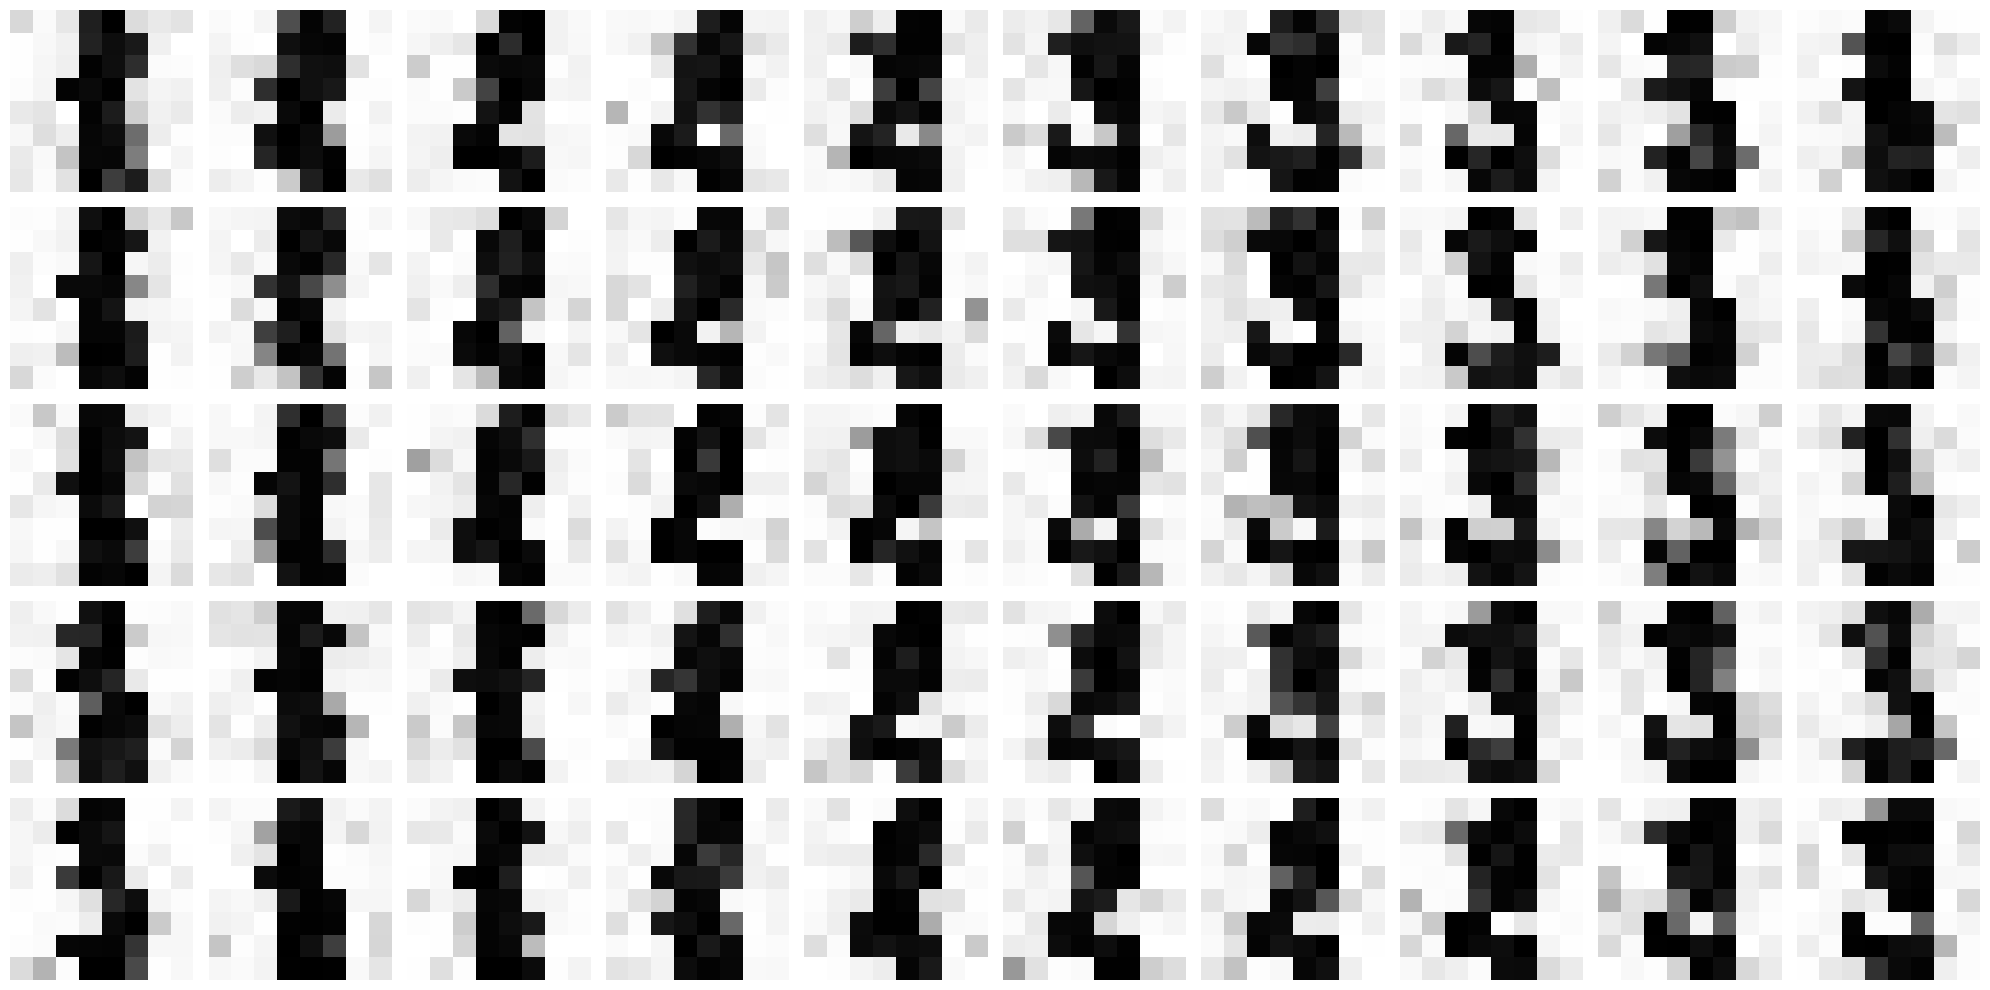

In [226]:
fig, axes = plt.subplots(5, 10, figsize=(20, 10))
axes = axes.flatten()
for i, ax in enumerate(axes):
    sns.heatmap(np.array(acts[i+10]).reshape(8,8), cmap="gray_r", ax=ax, cbar=False)
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.show()

  ** Noise: 0


100%|██████████| 3/3 [00:02<00:00,  1.01it/s]


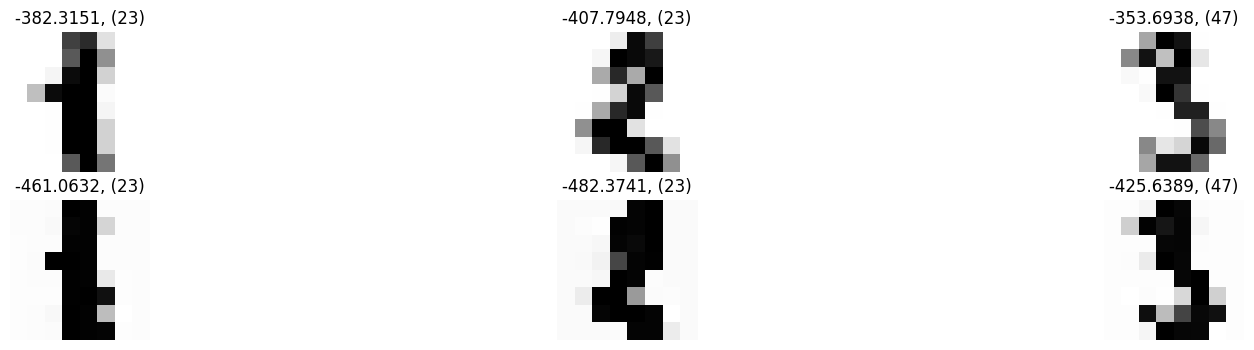

[array([-0.90288564, -0.90288734, -0.89395016,  0.92772164,  0.90749495,
        -0.90028988, -0.90216315, -0.90270948, -0.90288256, -0.90231346,
        -0.87466679,  0.8948815 ,  0.90994825, -0.6187639 , -0.90212455,
        -0.90255703, -0.90307682, -0.90252808, -0.89942102,  0.90867119,
         0.90704861, -0.89955458, -0.90247444, -0.90232051, -0.90299654,
        -0.89213355,  0.9190238 ,  0.93219895,  0.90873427, -0.90150859,
        -0.90267223, -0.90182199, -0.90294999, -0.90271066, -0.89998355,
         0.91462843,  0.90905729, -0.75843228, -0.90298625, -0.90265723,
        -0.90301133, -0.90503416, -0.90455038,  0.91211094,  0.93237412,
         0.80662162, -0.90336047, -0.90280665, -0.90293977, -0.90259084,
        -0.87176695,  0.92059984,  0.91000916, -0.44331117, -0.92467333,
        -0.90183692, -0.90296146, -0.90220506, -0.89362384,  0.92309671,
         0.90894171,  0.8974486 , -0.90722171, -0.90273355]),
 array([-0.90260279, -0.90234075, -0.90303629, -0.89376333,  0

In [238]:
nw_sym = AttractorNetwork(J_symmetrized, biases = np.zeros(nw.get_J().shape[0]))
get_deterministic_attractors(nw_sym, data, noise_levels=[0], inverse_temperature=1 )

In [237]:
nw_sym = AttractorNetwork(J_symmetrized, biases = np.zeros(nw.get_J().shape[0]))
for i, node in enumerate(nw.sigmas):
    node.activation = data[0][i]

for i in tqdm(range(1000)):
    nw_sym.update()
    print(nw_sym.vfe())

  6%|▌         | 56/1000 [00:00<00:03, 257.45it/s]

-486.8472533760571
-450.8149601457726
-408.62872240671066
-371.04686345258574
-373.99155264915726
-400.547321428162
-417.34183917672794
-440.5102605091153
-455.4810935189029
-419.7699876943696
-468.4394862790064
-477.75069143856155
-443.7619581928775
-394.6399963373468
-369.3891508568132
-373.793970515047
-375.292016810822
-411.40934253604763
-416.73605586107374
-441.41225327828363
-449.90117638260466
-420.383271718746
-475.67345865397255
-470.908291839086
-442.67246881950103
-410.2663763281921
-371.776251858375
-369.07875721712287
-372.9878609056657
-389.4207864831822
-411.19869898636796
-425.52332079896814
-455.71011916858146
-420.52930150301336
-471.4327008590262
-476.1316512372456
-437.8704105262068
-413.4161605958272
-371.23040801144066
-371.3916412375903
-403.38615238561454
-416.8078418311124
-444.277315255341
-451.32234843866945
-419.6733701820286
-465.0485507701543
-478.59778591169635
-440.85770209638036
-386.5018750147323
-372.1658522608665
-374.52863392487313
-405.91025199868

 12%|█▎        | 125/1000 [00:00<00:04, 183.55it/s]

-455.86324706368066
-429.80295221657934
-442.53402667972387
-479.74210096617446
-448.06998178473464
-410.03071425423883
-400.37453216516053
-370.3386288326533
-373.90402700905037
-382.6437986598368
-413.310847322844
-430.93260121813046
-454.90286596756056
-434.7558826928056
-427.6473290691575
-479.91516156930675
-447.83948349428266
-402.4402290850038
-379.41685550647105
-371.47381383598963
-375.12903785821857
-405.27743332230784
-417.826635677773
-444.1719643845697
-445.2329742936347
-425.30473828996105
-478.82073867976374
-458.8733636531742
-430.4876356288618
-389.4297496222373
-369.38822884197805
-373.46046256920334
-413.35115737034147
-419.77873246744434
-448.2760530029609
-442.7068353448509
-423.0141454585179
-475.5306791780488
-470.2503947725781
-434.03436882371625
-391.9681286890767
-370.8257839199672
-374.9022960670095
-372.8684600666071
-409.0265361561148
-424.77147184542997
-454.36948335055456
-418.67463127369433
-471.35797790651185


 14%|█▍        | 144/1000 [00:00<00:05, 148.06it/s]

-473.6455381991381
-439.36476926280005
-393.7665271831995
-367.6104819881318
-374.5571257737128
-381.78102654946713
-414.961960630853
-441.79701956454875
-451.0747244058796
-419.3881793512104
-478.19016543544365
-468.5692177178838
-434.4094193252915
-399.83586784654716
-390.95450529747865
-364.9536343005959
-372.7722421747353
-405.6670273969683
-416.0276786251218
-439.2633720562055
-452.0160427299439
-419.76107543763294
-473.684989921774


 20%|█▉        | 198/1000 [00:01<00:06, 126.15it/s]

-470.53124293641014
-434.1762283333673
-401.3919804434286
-369.176839247595
-373.79484514333217
-377.1995791886077
-404.60238175947524
-414.8316062581465
-437.39881474543375
-451.72148368320927
-419.41032009152275
-470.06212606121227
-472.19813695341
-436.6661292739595
-397.1809966351316
-368.09210531982853
-369.4611839840794
-380.8984469096438
-413.64571141523425
-421.6377248020211
-454.7307520192456
-441.7478181198595
-427.99646080216763
-478.2954367545285
-453.5797206463073
-413.3951029003368
-377.65864613230974
-372.0037051124755
-371.2923284375855
-373.27314037664354
-392.3041100272718
-416.5131146852093
-435.5365955575034
-454.22556672615366
-420.07161815329846
-472.33228586038905
-475.87398105774963
-441.46928227255785
-406.22419577781193
-369.69482399675
-374.6636458051337
-389.89819103819525
-414.0700312508792
-430.69949300077616
-453.7578583305793
-420.0728146920675
-475.92018645478186
-469.2037147598085
-418.98992978568293
-388.9164998059557


 28%|██▊       | 283/1000 [00:01<00:03, 220.38it/s]

-371.5837526187257
-372.0547629978315
-408.89620349374877
-419.8081444463217
-451.3148394111896
-446.59220461856756
-429.02884525915204
-477.9676976466042
-467.5209898604029
-419.26198244226384
-397.122331783681
-370.6113914059173
-376.1590755744041
-411.53976252193013
-424.78973636023886
-448.0274273098515
-437.37763144443363
-454.8000641897514
-468.00097284889205
-432.58130685576157
-411.3267767875567
-384.5280529071032
-369.5195788506437
-374.5388420148122
-399.2949181293252
-417.56073030315605
-448.2332127453175
-443.8400395710821
-432.37995562170363
-476.1952075390233
-452.64662600451675
-407.0174465312276
-389.5626509503781
-367.2698884597816
-371.66385914358796
-398.8352685300809
-416.0496933353503
-444.98518698771943
-444.89655274145485
-422.1719259162533
-475.33040842068783
-474.01498619573806
-437.51071691233733
-427.493448988869
-388.95067895326736
-370.21595543846513
-373.11215729570694
-377.4584556925311
-413.0003704341322
-425.6586473704109
-453.5291519780993
-419.9128416

 38%|███▊      | 382/1000 [00:01<00:02, 280.99it/s]

-453.73892969101564
-437.64841005847273
-411.82002102676125
-370.6192733140184
-371.84079206981664
-400.7512382626642
-414.4061085408325
-435.0570144410365
-449.4849826183935
-424.0361733245589
-482.0717143254959
-437.07240409475764
-419.20067422889423
-370.1371393162375
-372.91798608609
-376.1759799431511
-408.7075172523831
-416.9290472600645
-446.2193657131677
-449.87777109672106
-421.5033296729556
-477.19859316858714
-470.10829437132355
-433.7363536105997
-397.4381873874439
-370.6138199172285
-370.57386474324255
-377.8903300606263
-406.5893279799668
-417.55309359460995
-446.60395491121784
-447.3206973021812
-421.0949733338782
-471.3582713049
-471.1481087578954
-434.66785240761527
-404.1146132490077
-377.94665487801865
-369.3670599502847
-374.61890923946555
-404.0119831846904
-416.8925173089676
-436.51267562601254
-450.84696272178513
-428.1511367128039
-475.38383599660415
-446.28630985929146
-403.2088103232054
-369.02857525058874
-374.7352307240342
-390.3391698044933
-410.45338462236

 41%|████      | 412/1000 [00:02<00:02, 235.41it/s]

-452.9866008214399
-419.35997821569526
-458.8798497861838
-474.55607217031985
-438.15551044580576
-407.436574594078
-377.71676014931444
-366.2559760129672
-373.5208330411872
-403.4040533343216
-416.16756091821355
-439.6870920798026
-450.4020847217888
-421.2963903832517
-475.4659629835186
-477.47743444301403
-432.0870975066187
-381.03713896931487
-371.39457027324306
-376.78488431228493
-413.7318226644204
-416.24947162882444
-445.01812830703454
-448.9761075396943
-419.229784141971
-466.1313146920607
-480.3291640468959
-420.07096172099114
-382.0803154738718
-371.73760849943915
-381.92348993368597
-411.042055373246
-426.5567384650015
-447.6888041028318
-418.8717323847949
-475.74427947848085
-470.6973084101753
-426.34348401332153
-422.08595528992737
-400.90106976823375
-371.5976430380739
-372.32701538719186
-373.6125170429906
-398.4467676154253
-414.9997236283728
-447.9338945963502
-445.9613441818
-421.17368633704336
-469.36468603313097
-473.5055827719201


 48%|████▊     | 480/1000 [00:02<00:03, 165.58it/s]

-441.82894329707347
-434.43561895852974
-386.8840104967224
-367.4233696141578
-371.4416492671702
-393.35864297999615
-414.1056202865911
-437.7582786831135
-449.93924862458033
-423.87961096266315
-477.4277884043463
-464.5178181430788
-433.87224549479
-375.169235296759
-372.89666560800606
-378.46671786715
-410.51667947715697
-429.5894576902257
-448.11526561499915
-420.64570869042655
-469.63061751303707
-464.5874610131377
-430.05843423064175
-399.55099574340164
-373.4940944454638
-373.2268958023232
-373.31016872235375
-386.94604349924947
-414.1935584733076
-442.7812752049988
-452.7405482756897
-421.45171556768264
-474.1197630411814
-469.1343194759354
-425.93402589849774
-392.4576662418228
-384.5014251236684
-369.29987107761656
-381.42389276496743
-414.0791454150648
-427.2152182520255
-455.7172674236636
-421.3959400719589
-459.3561265615439
-478.19111213787096
-438.47125440933445
-410.77777749752033
-366.7773260349381
-370.3434926509283
-402.28897958119967
-415.490063068091
-431.5848807403

 61%|██████    | 609/1000 [00:03<00:01, 274.63it/s]

-420.45489266933095
-475.6263131579615
-473.5706367243846
-427.0823970487834
-383.28754142061916
-370.9102641990879
-372.7180425702311
-399.69895206713795
-413.6728249272521
-426.6883593068212
-454.52705697093955
-421.7173908221129
-448.3953874632101
-481.6003360814137
-442.6387915975848
-397.03386517589763
-378.2500165310036
-373.47556054720576
-372.6451643540595
-401.56159982395064
-417.2778625241516
-445.35989080692707
-446.7492074155534
-421.64678850780376
-476.96136500337116
-460.867648319011
-430.2358940075143
-398.3145228576181
-376.76941163962664
-372.19214944381764
-377.85696870437596
-413.28594756803346
-427.59148992309963
-454.00839161424585
-421.0608966290081
-448.0919631103726
-478.38045687211
-434.3642630067526
-369.0734362304879
-373.5113926915615
-405.8875044178369
-415.58371628561486
-440.09505946260936
-450.1090754085617
-418.76114738408694
-471.751208646517
-468.1162584619563
-434.6610305858424
-409.49439108777773
-372.9093760831233
-369.40785345565666
-378.222011784

 70%|██████▉   | 699/1000 [00:03<00:01, 273.79it/s]

-420.74494410785155
-476.3688931724169
-469.7276905645214
-419.6412322227515
-372.75887555783333
-372.65889791980067
-392.1153972089668
-414.1906725846809
-427.9237186486565
-455.2338524118099
-432.1539422248627
-430.3280218618189
-475.2832176102624
-471.20688210672404
-440.5118984045853
-416.97801354517776
-369.2243209017562
-373.19312161113396
-401.1207152490011
-416.7921573736502
-451.581668490854
-449.224293333132
-424.92122652364316
-477.8559874609548
-467.27309618478154
-434.840000637529
-377.7851789617798
-372.9651025850218
-393.65879193318005
-416.65193453992345
-436.84851885595873
-449.1751342986564
-429.2943973467343
-473.1981322142941
-470.5349269933256
-433.53093752823565
-411.1797050368077
-384.77894248568015
-366.6204440158327
-371.0139973073452
-400.8075061844696
-420.2873672952626
-445.75174187353923
-427.7331304782197
-430.13729918768877
-467.5357465001285
-467.02699582296634
-417.46586795907024
-417.8299771207774
-415.41495700226164
-382.7042923634718
-373.97358472318

 78%|███████▊  | 783/1000 [00:03<00:00, 256.90it/s]

-454.09476579185207
-438.1610570769708
-442.8300854618
-479.04326556886696
-447.93018721617045
-413.2901073089497
-402.2328511524
-379.7341402869182
-373.03535529685064
-375.440001124554
-413.46045089702864
-414.2234826709006
-432.0256090346759
-450.83094846916214
-420.5521233192676
-469.8658625445038
-476.40649752485353
-443.0930724135768
-410.2382470592819
-377.4979977697743
-370.62726517361494
-374.9846358009823
-407.01786620410354
-418.51558069433145
-444.83288367797036
-448.62891565514957
-429.28722759410346
-479.1381434205313
-468.2752397087248
-438.42268138510696
-402.1333041543714
-365.96135721501264
-372.3105836974558
-412.71394633834933
-417.3554955370845
-441.86379766233017
-446.8733424935383
-419.5956072433524
-474.0676808445839
-470.7035122436179
-429.66535041019495
-403.6814861589866
-367.84371187110696
-373.4923625608267
-398.56051592433766
-425.07310063096315
-450.99877364620704
-434.8196138165533
-430.65782251372286
-473.6056424339208
-451.3216215759146
-416.9010087197

 84%|████████▎ | 837/1000 [00:04<00:00, 242.53it/s]

-451.1057995099506
-418.4113315292533
-374.10660432215565
-371.98212968363697
-375.16374926709796
-411.5183036830845
-418.2291877157187
-448.61355371114814
-440.7080142894678
-420.21323121083117
-474.99306348097684
-468.86576525970895
-432.53650199488516
-374.64791405061453
-368.48667135832574
-373.72851868118505
-374.7927747109446
-400.4995916608891
-415.4119459675209
-451.31181972646186
-435.9980718451128
-426.43401679074645
-472.80685888319067
-465.97884943150837
-429.9849341811912
-417.4327238514171
-380.46844023022396
-372.37922048773123
-373.9973004475031
-407.0371067334788
-419.0676852448066
-445.38492494626337
-444.8314915230304
-430.68426239901305
-477.1685033080986
-451.32769601511063
-411.7043099752276
-376.9693264284142
-372.9081211050023
-389.51210445126424
-414.4042238836435
-440.0010022836164
-451.2096978947859
-424.4275099788791
-447.41740522859357
-478.36152471472667
-453.52425396212334
-409.59412428103695
-371.67528316524863
-374.24967863466077
-413.7885716849902
-422

 94%|█████████▍| 939/1000 [00:04<00:00, 236.28it/s]

-437.892467179568
-447.2490336219225
-418.75487736260897
-472.4544395560559
-473.2553638925159
-441.78276547991356
-404.23840076818436
-371.9435217340762
-373.41913606250506
-375.21802899157433
-411.60976360332336
-418.8708824240813
-447.7761401410958
-433.3058890045605
-451.74526492728194
-479.23998891763136
-441.6402762311999
-420.73849909760395
-386.25238510880826
-372.06988678612487
-372.63423017229616
-383.20530222186926
-402.1270286461564
-413.77748913646786
-439.5662671502666
-450.5389512278256
-421.3792561905877
-466.38125794222054
-478.05219418084397
-440.078172249489
-393.2301049193945
-374.11239702515957
-373.7115355440026
-401.15893968825026
-411.67967938653254
-437.27058058102523
-448.7905789807959
-419.4924857079931
-457.40520757570135
-472.62605305983186
-426.30216353931405
-376.0434958087294
-369.4865168530487
-372.16649355288723
-402.155310964936
-416.0896224239834
-430.3698702675026
-454.528415889956
-426.1468931961008
-446.42000879369505
-480.17108650516144
-449.4866

100%|██████████| 1000/1000 [00:04<00:00, 213.92it/s]

-441.50437575545675
-450.55760256516976
-418.6386998517608
-457.1485677088436
-466.51397580844514
-437.9825044484065
-401.3027557122507
-370.80209049008744
-373.0569178360581
-384.327776721913
-413.1995526997566
-430.3209203177743
-449.6653454480259
-421.13532066258045
-475.8284290065904
-472.6722960793354
-432.63879308332685
-390.6244381959683
-370.3268034698372
-370.67486084564854
-406.201320721962
-417.3540472653218
-441.7925063464828
-455.6049332226248
-421.0835368297344
-467.32580964117346
-476.05775383423224
-435.1906581209265
-424.8623489855703
-380.82730408811386
-372.29849563872847
-382.98758577638046
-412.5328318555633
-422.6077677076204
-455.19796995661943
-440.75383705365016
-439.5135585159937
-477.1632492298037
-466.22685419061094
-433.8262353056359
-399.7991438230397
-369.78952055705713
-373.37066555216967
-370.4178851092577
-390.55546082510875
-411.6661430986486
-444.328898602123
-445.9619872670023
-420.5660821339421
-474.9359734886504
-467.9626554913296
-404.23644297658